# フルーツ選別器
大体の流れは紙に書くきます

# 3/5すること　訓練データとテストデータを読込んでモデルを作成

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


#%matplotlib inline = jupyter内で自動的に描画してくれる関数を実装した
#%config InlineBackend.figure_format = 'retina' = retinaにより高解像度化してグラフ表示

In [2]:
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import numpy

import helper

import numpy as np

#-------モデル作成のためのライブラリ-----------#

import torch.nn as nn
import torch.nn.functional as f
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
torch.cuda.empty_cache()

CUDA is available!  Training on GPU ...


In [4]:
datadir = 'C:/Users/throb/Desktop/Udacity/fruits'
test_transform = transforms.Compose([transforms.ToTensor()])
train_transform = transforms.Compose([transforms.ToTensor()])

test_ds = datasets.ImageFolder(datadir + '/test',transform = test_transform)
train_ds = datasets.ImageFolder(datadir + '/train',transform =train_transform )

test_ld = torch.utils.data.DataLoader(test_ds,batch_size = 32, shuffle = True)
train_ld = torch.utils.data.DataLoader(train_ds,batch_size = 32, shuffle = True)


classes = ['Apple', 'Banana', 'Starfruits']

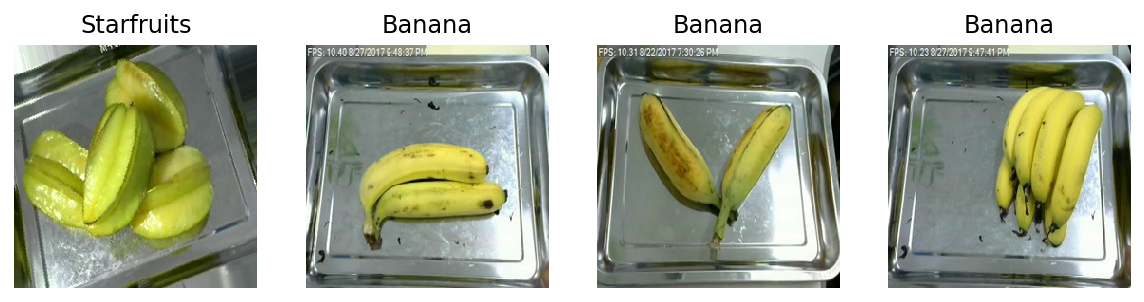

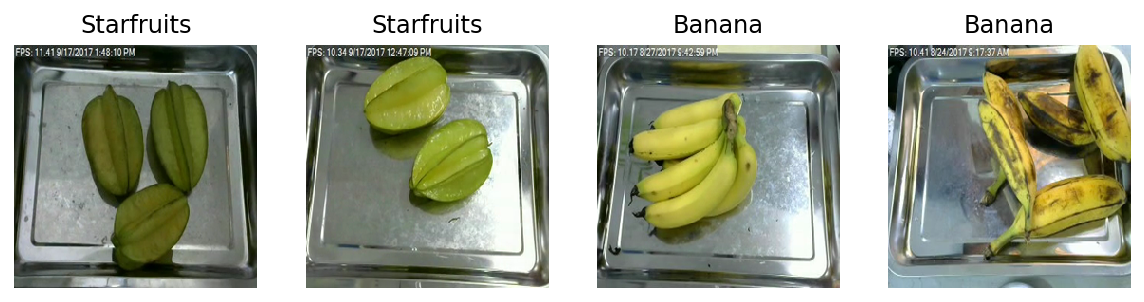

In [5]:
data_iter = iter(test_ld)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)
    ax.set_title(classes[labels[ii]])
    
data_iter = iter(train_ld)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)
    ax.set_title(classes[labels[ii]])

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        #256/2 = 128
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        #128/2 = 64
        self.conv3 = nn.Conv2d(32, 64, 3, padding =1)
        #64/2 = 32
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        #32/2 = 16
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128 * 16 * 16,24000)
        self.fc2 = nn.Linear(24000,12000)
        self.fc3 = nn.Linear(12000,3000)
        self.fc4 = nn.Linear(3000,500)
        self.fc5 = nn.Linear(500,10)
    def forward(self,x):
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = self.pool(f.relu(self.conv3(x)))
        x = self.pool(f.relu(self.conv4(x)))
        x = x.view(-1,128 * 16 * 16)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.relu(self.fc3(x))
        x = f.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x

model = Net()
print(model)
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=24000, bias=True)
  (fc2): Linear(in_features=24000, out_features=12000, bias=True)
  (fc3): Linear(in_features=12000, out_features=3000, bias=True)
  (fc4): Linear(in_features=3000, out_features=500, bias=True)
  (fc5): Linear(in_features=500, out_features=10, bias=True)
)


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.2)

In [8]:
epochs = 8

valid_loss_min = np.Inf

for epoch in range(1, epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_ld:
        
        if train_on_gpu:
            data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    model.eval()
    for data, traget in train_ld:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output,target)
        valid_loss += loss.item() * data.size(0)
        
    train_loss = train_loss/len(train_ld.dataset)
    valid_loss = valid_loss/len(train_ld.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 6.00 GiB total capacity; 4.29 GiB already allocated; 52.13 MiB free; 4.31 GiB reserved in total by PyTorch)